In [210]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoLars
from sklearn.cross_validation import train_test_split
from statsmodels.discrete.discrete_model import Logit
from pandas.tools.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from __future__ import division
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import scale, StandardScaler
from bokeh.charts import Histogram
from bokeh.sampledata.autompg import autompg as df
from bokeh.charts import defaults, vplot, hplot, show, output_file
from bokeh.charts import Bar, output_file, show
import pygal
import matplotlib.cm as cm, matplotlib.font_manager as fm

%matplotlib inline

In [2]:
X_ver2 = pd.read_csv('X_ver2.csv')

In [3]:
X_ver2 = X_ver2[X_ver2['HR9'].notnull()]

In [4]:
y = X_ver2.pop('Rookie?')

In [5]:
X_ver2 = X_ver2.drop(['player_id', 'Year'], axis=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_ver2, y)

In [235]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_sample(X_train, y_train)

In [236]:
#logit_mod = Logit(y_resampled, X_resampled).fit()
#logit_mod.summary()

In [345]:
sklogit = LogisticRegression()
RF = RandomForestClassifier(n_estimators=200, n_jobs=4)
GB = GradientBoostingClassifier(n_estimators=500)

In [346]:
sklogit.fit(X_resampled, y_resampled)
RF.fit(X_resampled, y_resampled)
GB.fit(X_resampled, y_resampled)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [347]:
print sklogit.score(X_test, y_test)
print RF.score(X_test, y_test)
print GB.score(X_test, y_test)

0.768037328667
0.779994167396
0.779819189268


In [348]:
y_pred_logit = sklogit.predict(X_test)
y_pred_RF = RF.predict(X_test)
y_pred_GB = GB.predict(X_test)
y_proba_logit = sklogit.predict_proba(X_test)
y_proba_RF = RF.predict_proba(X_test)
y_proba_GB = GB.predict_proba(X_test)

In [349]:
print precision_score(y_test, y_pred_logit)
print precision_score(y_test, y_pred_RF)
print precision_score(y_test, y_pred_GB)

0.0457516339869
0.0451282051282
0.0443931229151


In [350]:
print recall_score(y_test, y_pred_logit)
print recall_score(y_test, y_pred_RF)
print recall_score(y_test, y_pred_GB)

0.84375
0.785714285714
0.772321428571


In [351]:
print roc_auc_score(y_test, y_pred_logit)
print roc_auc_score(y_test, y_pred_RF)
print roc_auc_score(y_test, y_pred_GB)

0.805392522605
0.782816365125
0.776119936554


In [ ]:
confusion_matrix(y_test, y_pred_logit)

In [ ]:
y_test.value_counts()

In [246]:
y_test.shape

(19288,)

In [247]:
y_test_copy = y_test.copy()

In [248]:
y_test_copy.index = range(y_test_copy.shape[0])

In [249]:
true_idx_0 = y_test_copy[y_test_copy == 0].index

In [250]:
true_idx_1 = y_test_copy[y_test_copy==1].index

In [251]:
pred_idx_1 = np.where(y_pred_logit == 1)

In [252]:
pred_idx_0 = np.where(y_pred_logit == 0)

In [253]:
FP_idx = np.intersect1d(true_idx_0, pred_idx_1) # 실제로는 0인데 1로 예상한것들

In [254]:
TP_idx = np.intersect1d(true_idx_1, pred_idx_1) # 실제로 1이고 1로 예상한것들

In [255]:
FN_idx = np.intersect1d(true_idx_1, pred_idx_0) # 실제로 1인데 0으로 예상한것들

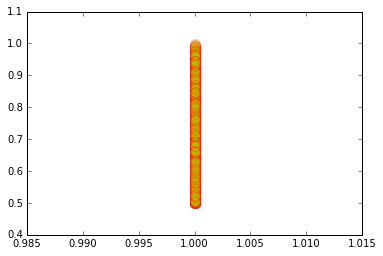

In [256]:
plt.scatter(y_pred_logit[FP_idx], y_proba_logit[:,1][FP_idx], alpha=0.2, s=100, c='y', edgecolor='red')

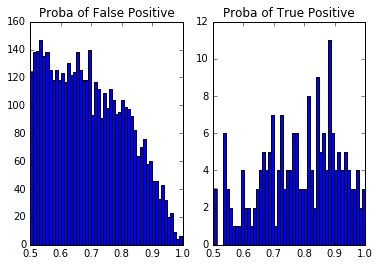

In [257]:
f, ax = plt.subplots(1, 2)
_ = ax[0].hist(y_proba_logit[:,1][FP_idx], bins=50)
ax[0].set_title('Proba of False Positive')
_ = ax[1].hist(y_proba_logit[:,1][TP_idx], bins=50)
ax[1].set_title('Proba of True Positive')

In [258]:
(y_proba_logit[:,1][TP_idx] > 0.75).sum()

118

In [259]:
(y_proba_logit[:,1][FP_idx] > 0.75).sum()

1562

In [260]:
thres = np.linspace(0.2, 1.0, 50)

In [261]:
TPR = []
Precision = []
for t in thres:
    TPR.append((y_proba_logit[:,1][TP_idx] > t).sum() / 222.)
    Precision.append((y_proba_logit[:,1][TP_idx] > t).sum() / ((y_proba_logit[:,1][FP_idx] > t).sum() + (y_proba_logit[:,1][TP_idx] > t).sum()))

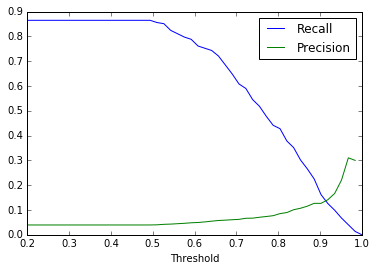

In [263]:
plt.plot(thres, TPR, label='Recall')
plt.plot(thres, Precision, label='Precision')
plt.legend()
plt.xlabel('Threshold')

In [267]:
X_ver2.drop('Number_row', axis=1).head().T

,0,1,2,3,4
Lev,6.000000,6.000,6.000,5.000,5.00
AgeDif_pitching,-0.833333,-1.000,-0.100,-2.300,-1.20
Age_pitching,21.000000,22.000,23.000,24.000,25.00
BF,78.333333,400.000,224.000,173.000,75.00
Drafted,100.000000,100.000,100.000,100.000,100.00
ERA,11.714014,3.260,2.290,5.700,2.70
G_pitching,4.666667,22.000,31.000,9.000,3.00
HR9,2.746892,1.300,0.200,1.200,1.10
Height,154.940000,154.940,154.940,154.940,154.94
IP,18.766667,99.100,51.000,36.100,16.20


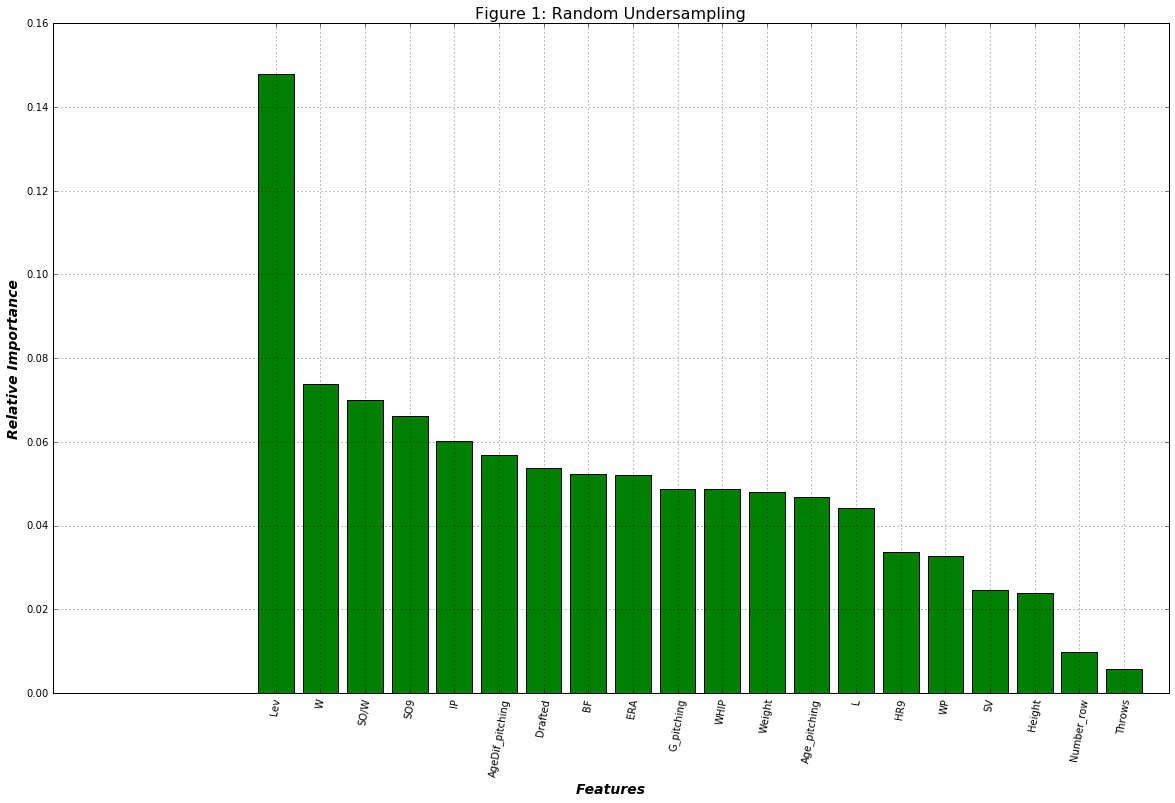

In [268]:

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(20,12))
_ = plt.bar(range(X_train.shape[1]), importances[indices], align='center', label = X_train.columns[indices], color='green')
_ = plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=80)
plt.grid(True)
plt.xlabel('Features', fontsize=14, fontweight='bold', style='italic')
plt.ylabel('Relative Importance', fontsize=14, fontweight='bold', style='italic')
plt.title('Figure 1: Random Undersampling', fontsize=16)



In [274]:
sorted_ix = np.argsort(f_regression(X_resampled, y_resampled)[1])

In [275]:
zip(X_ver2.columns[sorted_ix], f_regression(X_resampled, y_resampled)[1][sorted_ix])

[('Lev', 9.3068426204334364e-74),
 ('W', 9.0515638705714198e-43),
 ('IP', 1.4880634594341871e-26),
 ('Drafted', 1.5293776325530845e-23),
 ('BF', 2.1863948310613192e-23),
 ('Weight', 3.5910132601610574e-23),
 ('L', 1.6295369401072979e-22),
 ('AgeDif_pitching', 1.0272469211480599e-20),
 ('SO9', 1.5124418040936471e-19),
 ('SO/W', 1.9048277746758295e-18),
 ('Number_row', 8.8041561669854441e-13),
 ('G_pitching', 1.5963137461405463e-10),
 ('SV', 2.1492637225482847e-05),
 ('WP', 0.00081392032278829369),
 ('Height', 0.0012193485799165335),
 ('HR9', 0.0075091402880290477),
 ('WHIP', 0.065471141352417148),
 ('ERA', 0.16453994043633824),
 ('Throws', 0.17311766383844931),
 ('Age_pitching', 0.54735989978577915)]

In [11]:
pca = PCA()

In [14]:
X_pca = pca.fit_transform(X_ver2)

In [19]:
X_pca

array([[ -1.29783298e+02,  -4.83981924e+01,   3.98907895e+00, ...,
          6.45516250e-01,  -4.50102700e-03,   3.75286410e-01],
       [  2.01940173e+02,  -6.22372208e+01,   4.55601871e+00, ...,
          5.73986062e-01,  -3.40746585e-01,  -2.97053133e-02],
       [  2.01805624e+01,  -5.48349197e+01,   4.22881414e+00, ...,
          6.21953776e-01,  -2.14841097e-01,  -1.58879008e-01],
       ..., 
       [  4.54457377e+02,   2.82727262e+01,  -9.60067199e-01, ...,
         -3.33719005e-01,  -1.92459401e-01,   1.77840715e-02],
       [  1.11461148e+02,   4.24419324e+01,  -1.45920735e+00, ...,
         -3.03398146e-01,   1.52889161e-01,  -1.55354661e-01],
       [ -6.17249683e+01,   4.91054056e+01,  -1.32720482e+00, ...,
         -3.23710419e-01,  -1.29169519e-01,  -9.72408549e-02]])

In [279]:
X_ver2.columns

Index([u'Number_row', u'Lev', u'AgeDif_pitching', u'Age_pitching', u'BF',
       u'Drafted', u'ERA', u'G_pitching', u'HR9', u'Height', u'IP', u'L',
       u'SO/W', u'SO9', u'SV', u'Throws', u'W', u'WHIP', u'WP', u'Weight'],
      dtype='object')

In [ ]:
_ = scatter_matrix(X_ver2, alpha=0.2, figsize=(6, 6), diagonal='kde')

## Dropping anything AFTER the first promotion year

In [4]:
ix = []
for i, y in X_ver2[X_ver2['Rookie?'] == 1][['player_id', 'Year']].values:
    ix.extend(X_ver2[(X_ver2['player_id'] == i) & (X_ver2['Year'] > y)].index)

In [5]:
len(ix)

3725

In [6]:
X_ver2[X_ver2['Rookie?'] == 1][['player_id', 'Year']].values

array([[11114,  2004],
       [11132,  2015],
       [11157,  2006],
       ..., 
       [38085,  2006],
       [38098,  2005],
       [38104,  2013]])

In [7]:
X_ver2.shape

(77151, 23)

In [8]:
X_ver2 = X_ver2.drop(X_ver2.index[ix])

## Dropping everything before 1999

In [9]:
X_ver2[X_ver2.Year < 1999].shape

(4869, 23)

In [10]:
X_ver2[X_ver2['Rookie?'] == 1].Year.value_counts()

2014    65
2005    62
2007    58
1999    57
2012    55
2010    53
2008    53
2006    49
2013    49
2000    49
2011    46
2001    46
2015    46
2004    41
2003    41
2002    41
2009    37
Name: Year, dtype: int64

In [11]:
X_ver2 = X_ver2[X_ver2.Year >= 1999]

In [12]:
X_ver2_copy = X_ver2.copy()

In [13]:
Id = X_ver2_copy.pop('player_id')

In [14]:
yeaR = X_ver2_copy.pop('Year')

In [15]:
label = X_ver2_copy.pop('Rookie?')

In [16]:
X_ver2 = X_ver2.drop('Number_row', axis=1)

In [17]:
X_ver2.columns

Index([u'player_id', u'Year', u'Lev', u'AgeDif_pitching', u'Age_pitching',
       u'BF', u'Drafted', u'ERA', u'G_pitching', u'HR9', u'Height', u'IP',
       u'L', u'Rookie?', u'SO/W', u'SO9', u'SV', u'Throws', u'W', u'WHIP',
       u'WP', u'Weight'],
      dtype='object')

In [18]:
X_ver2[['ERA_diff', 'IP_diff', 'HR9_diff', 'L_diff', 'SO/W_diff', 'SO9_diff', 'SV_diff', 'W_diff', 'WHIP_diff', 'WP_diff']] =\
X_ver2[['ERA', 'IP', 'HR9', 'L', 'SO/W', 'SO9', 'SV', 'W', 'WHIP', 'WP']]

## Save a copy

In [19]:
copy_before_new_col = X_ver2.copy()

In [20]:
X_ver2.index = range(X_ver2.shape[0])

In [21]:
group_idx = X_ver2.groupby('player_id').groups.values()

In [22]:
for group in group_idx:
    for i, idx in enumerate(group):
        if i == 0:
            X_ver2.set_value(idx, ['ERA_diff', 'IP_diff', 'HR9_diff', 'L_diff',
                                   'SO/W_diff', 'SO9_diff', 'SV_diff', 'W_diff', 'WHIP_diff', 'WP_diff'], 0)
        else:
            X_ver2.set_value(idx, ['ERA_diff', 'IP_diff', 'HR9_diff', 'L_diff',
                                   'SO/W_diff', 'SO9_diff', 'SV_diff', 'W_diff', 'WHIP_diff', 'WP_diff'],
                             X_ver2.ix[idx][['ERA', 'IP', 'HR9', 'L', 'SO/W', 'SO9', 'SV', 'W', 'WHIP', 'WP']].values -\
                             X_ver2.ix[idx-1][['ERA', 'IP', 'HR9', 'L', 'SO/W', 'SO9', 'SV', 'W', 'WHIP', 'WP']].values)

In [26]:
X_ver2.to_csv('batter_808.csv')

In [312]:
X_ver2_bat = X_ver2.drop(['player_id', 'Year'], axis=1)

In [313]:
y = X_ver2_bat.pop('Rookie?')

In [ ]:
Under

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X_ver2_808x, y)

In [196]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_sample(X_train, y_train)

In [197]:
sm = SMOTE(kind='regular')
X_over, y_over = sm.fit_sample(X_train, y_train)

In [319]:
#logit_mod = Logit(y_resampled, X_resampled).fit()
#logit_mod.summary()

In [198]:
d = {'Regular': [X_train, y_train], 'SMOTE': [X_over, y_over], 'Undersampling': [X_resampled, y_resampled]}

In [199]:
y_test_copy = y_test.copy()

In [200]:
y_test_copy.index = range(y_test_copy.shape[0])

In [201]:
true_idx_0 = y_test_copy[y_test_copy == 0].index

In [202]:
true_idx_1 = y_test_copy[y_test_copy==1].index

In [203]:
thres = np.linspace(0.0, 1.0, 100)

In [204]:
rec_logit

[]

In [194]:
acc_logit = []
acc_RF = []
acc_GB = []
prec_logit = []
prec_RF = []
prec_GB = []
rec_logit = []
rec_RF = []
rec_GB = []
auc_logit = []
auc_RF = []
auc_GB = []
CM_logit = []
CM_RF = []
CM_GB = []
roc_logit = []
roc_RF = []
roc_GB = []
for tpe in d:
    X_x, y_y = d[tpe]
    sklogit = LogisticRegression()
    RF = RandomForestClassifier(n_estimators=200, n_jobs=4)
    GB = GradientBoostingClassifier(n_estimators=500)
    sklogit.fit(X_x, y_y)
    RF.fit(X_x, y_y)
    GB.fit(X_x, y_y)
    acc_logit.append(sklogit.score(X_test, y_test))
    acc_RF.append(RF.score(X_test, y_test))
    acc_GB.append(GB.score(X_test, y_test))
    y_pred_logit = sklogit.predict(X_test)
    y_pred_RF = RF.predict(X_test)
    y_pred_GB = GB.predict(X_test)
    y_proba_logit = sklogit.predict_proba(X_test)
    y_proba_RF = RF.predict_proba(X_test)
    y_proba_GB = GB.predict_proba(X_test)
    prec_logit.append(precision_score(y_test, y_pred_logit))
    prec_RF.append(precision_score(y_test, y_pred_RF))
    prec_GB.append(precision_score(y_test, y_pred_GB))
    rec_logit.append(recall_score(y_test, y_pred_logit))
    rec_RF.append(recall_score(y_test, y_pred_RF))
    rec_GB.append(recall_score(y_test, y_pred_GB))
    auc_logit.append(roc_auc_score(y_test, y_pred_logit))
    auc_RF.append(roc_auc_score(y_test, y_pred_RF))
    auc_GB.append(roc_auc_score(y_test, y_pred_GB))
    CM_logit.append(confusion_matrix(y_test, y_pred_logit))
    CM_RF.append(confusion_matrix(y_test, y_pred_RF))
    CM_GB.append(confusion_matrix(y_test, y_pred_GB))
    auc_logit.append(roc_curve(y_test, y_pred_logit))
    auc_RF.append(roc_curve(y_test, y_pred_RF))
    auc_GB.append(roc_curve(y_test, y_pred_GB))
    
 '''   importances = RF.feature_importances_
    indices = np.argsort(importances)[::-1]
    fig1 = plt.figure(figsize=(20,12))
    _ = plt.bar(range(X_train.shape[1]), importances[indices], align='center', label = X_train.columns[indices], color='green')
    _ = plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=80)
    plt.grid(True)
    plt.xlabel('Features', fontsize=14, fontweight='bold', style='italic')
    plt.ylabel('Relative Importance', fontsize=14, fontweight='bold', style='italic')
    plt.title(tpe, fontsize=16)
    fig1.savefig('/home/jun/Galvanize/capstone/Galvanize_capstone/Images/Presentation/featimp_%s.png' % tpe)
    plt.close(fig1)'''
    
    for y_set in [[y_pred_logit, y_proba_logit, 'Logistic Regression'], [y_pred_RF, y_proba_RF, 'Random Forest'], [y_pred_GB, y_proba_GB, 'Gradient Boosting']]:
        y_pred, y_proba, model_name = y_set
        TP = confusion_matrix(y_test, y_pred)[1:,1]
        pred_idx_1 = np.where(y_pred == 1)
        pred_idx_0 = np.where(y_pred == 0)
        FP_idx = np.intersect1d(true_idx_0, pred_idx_1)
        TP_idx = np.intersect1d(true_idx_1, pred_idx_1)
        TPR = []
        Precision = []
        for t in thres:
            TPR.append((y_proba[:,1][TP_idx] > t).sum() / TP)
            Precision.append((y_proba[:,1][TP_idx] > t).sum() / ((y_proba[:,1][FP_idx] > t).sum() + (y_proba[:,1][TP_idx] > t).sum()))
        fig = plt.figure()
        plt.plot(thres, TPR, label='Recall')
        plt.plot(thres, Precision, label='Precision')
        plt.legend()
        plt.xlabel('Threshold')
        plt.ylabel('Ratio')
        plt.title('Pitchers: ' + tpe + ' + ' + model_name)
        fig.savefig('/home/jun/Galvanize/capstone/Galvanize_capstone/Images/Presentation/%s.png' % (tpe + '_' + model_name + '_pitchers'))
        plt.close(fig)

NameError: name 'd' is not defined

In [391]:
acc_logit

[0.75876348789734616, 0.98798483522892977, 0.77258675998833481]

In [392]:
rec_RF

[0.82692307692307687, 0.014423076923076924, 0.0625]

In [377]:
acc_under = [acc_logit[0], acc_RF[0], acc_GB[0]]
acc_reg = [acc_logit[1], acc_RF[1], acc_GB[1]]
acc_SMOTE = [acc_logit[2], acc_RF[2], acc_GB[2]]

rec_under = [rec_logit[0], rec_RF[0], rec_GB[0]]
rec_reg = [rec_logit[1], rec_RF[1], rec_GB[1]]
rec_SMOTE = [rec_logit[2], rec_RF[2], rec_GB[2]]

prec_under = [prec_logit[0], prec_RF[0], prec_GB[0]]
prec_reg = [prec_logit[1], prec_RF[1], prec_GB[1]]
prec_SMOTE = [prec_logit[2], prec_RF[2], prec_GB[2]]

auc_under = [auc_logit[0], auc_RF[0], auc_GB[0]]
auc_reg = [auc_logit[1], auc_RF[1], auc_GB[1]]
auc_SMOTE = [auc_logit[2], auc_RF[2], auc_GB[2]]

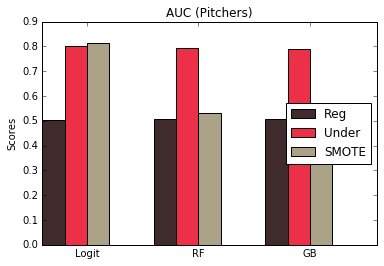

In [398]:
N = 3

ind = np.arange(N)  # the x locations for the groups
width = 0.20       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, auc_reg, width, color='#3f2b2c')

rects2 = ax.bar(ind + width, auc_under, width, color='#ec3047')

rects3 = ax.bar(ind + width + width, auc_SMOTE, width, color='#aca287')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('AUC (Pitchers)')
ax.set_xticks(ind + width + width)
ax.set_xticklabels(('Logit', 'RF', 'GB'))

ax.legend((rects1[0], rects2[0], rects3[0]), ('Reg', 'Under', 'SMOTE'), loc='right')
fig.savefig('/home/jun/Galvanize/capstone/Galvanize_capstone/Images/Presentation/AUC_pit.png')

In [30]:
X_ver2_808 = X_ver2.copy()

In [36]:
y = X_ver2_808.pop('Rookie?')

In [37]:
X_ver2_808x = X_ver2_808.drop(['player_id', 'Year'], axis=1)

In [78]:
X_ver2_808x = X_ver2_808x.drop(['W', 'L', 'SV', 'W_diff', 'L_diff', 'SV_diff'], axis=1)

In [79]:
X_train_808, X_test_808, y_train_808, y_test_808 = train_test_split(X_ver2_808x, y, train_size=0.8)
sm = SMOTE(kind = 'regular')
RU = RandomUnderSampler()

In [80]:
X_over_808, y_over_808 = sm.fit_sample(X_train_808, y_train_808)
X_under_808, y_under_808 = RU.fit_sample(X_train_808, y_train_808)

In [81]:
x_under_808df = pd.DataFrame(X_under_808)
x_under_808df.columns = X_ver2_808x.columns

In [82]:
stats_logit = Logit(y_under_808, x_under_808df).fit()

Optimization terminated successfully.
         Current function value: 0.421091
         Iterations 7


In [83]:
stats_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1386
Model:                          Logit   Df Residuals:                     1363
Method:                           MLE   Df Model:                           22
Date:                Tue, 09 Aug 2016   Pseudo R-squ.:                  0.3925
Time:                        01:33:23   Log-Likelihood:                -583.63
converged:                       True   LL-Null:                       -960.70
                                        LLR p-value:                2.861e-145
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Lev                 0.9258      0.084     10.959      0.000       0.760       1.091
AgeDif_pitching     0.4220      0.068      6.247      0.000       0.290       0.554
Age_pitching       -0.5653      0.060     -9.401      0.000      -0.683      -0.447
BF                 -0.0224      0.006     -3.462      0.001      -0.035      -0.010
Drafted             0.0027      0.002      1.329      0.184      -0.001       0.007
ERA                 0.0642      0.074      0.869      0.385      -0.081       0.209
G_pitching          0.0303      0.007      4.345      0.000       0.017       0.044
HR9                 0.0505      0.166      0.304      0.761      -0.275       0.376
Height              0.0124      0.007      1.840      0.066      -0.001       0.026
IP                  0.1168      0.028      4.165      0.000       0.062       0.172
SO/W               -0.0108      0.033     -0.324      0.746      -0.076       0.054
SO9                 0.1275      0.026      4.870      0.000       0.076       0.179
Throws              0.3605      0.168      2.142      0.032       0.031       0.690
WHIP               -0.7526      0.294     -2.558      0.011      -1.329      -0.176
WP                  0.0168      0.025      0.683      0.494      -0.031       0.065
Weight              0.0131      0.004      3.376      0.001       0.006       0.021
ERA_diff           -0.0636      0.062     -1.034      0.301      -0.184       0.057
IP_diff            -0.0043      0.003     -1.543      0.123      -0.010       0.001
HR9_diff           -0.0132      0.143     -0.092      0.927      -0.294       0.267
SO/W_diff          -0.0162      0.030     -0.532      0.595      -0.076       0.043
SO9_diff           -0.0226      0.026     -0.883      0.377      -0.073       0.028
WHIP_diff           0.2463      0.240      1.024      0.306      -0.225       0.718
WP_diff            -0.0186      0.022     -0.865      0.387      -0.061       0.024
===================================================================================
"""

In [84]:
bad_ix = np.where(stats_logit.pvalues >= 0.05)

In [85]:
X_ver2_808x.columns[bad_ix]

Index([u'Drafted', u'ERA', u'HR9', u'Height', u'SO/W', u'WP', u'ERA_diff',
       u'IP_diff', u'HR9_diff', u'SO/W_diff', u'SO9_diff', u'WHIP_diff',
       u'WP_diff'],
      dtype='object')

In [86]:
sklogit = LogisticRegression()
RF = RandomForestClassifier(n_estimators=200, n_jobs=4)

In [87]:
sklogit.fit(X_under_808, y_under_808)
RF.fit(X_under_808, y_under_808)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
print sklogit.score(X_test_808, y_test_808)
print RF.score(X_test_808, y_test_808)

0.764216972878
0.776538349373


In [89]:
y_pred_logit = sklogit.predict(X_test_808)
y_pred_RF = RF.predict(X_test_808)
y_proba_logit = sklogit.predict_proba(X_test_808)
y_proba_RF = RF.predict_proba(X_test_808)

In [90]:
print precision_score(y_test_808, y_pred_logit)
print precision_score(y_test_808, y_pred_RF)

0.0392098174199
0.0401390644753


In [91]:
print recall_score(y_test_808, y_pred_logit)
print recall_score(y_test_808, y_pred_RF)

0.845161290323
0.81935483871


In [92]:
print roc_auc_score(y_test_808, y_pred_logit)
print roc_auc_score(y_test_808, y_pred_RF)

0.804226541482
0.797701901325


In [93]:
confusion_matrix(y_test_808, y_pred_logit)

array([[10351,  3210],
       [   24,   131]])

In [ ]:
hist = Histogram(df['mpg'], title="df['mpg']")

In [118]:
df

,mpg,cyl,displ,hp,weight,accel,yr,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
5,15.0,8,429.0,198,4341,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220,4354,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215,4312,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225,4425,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190,3850,8.5,70,1,amc ambassador dpl


In [123]:
df_imp

,0,label
0,0.159374,Lev
1,0.077093,IP
2,0.073594,BF
3,0.070509,SO/W
4,0.062458,SO9
5,0.049406,AgeDif_pitching
6,0.045958,G_pitching
7,0.040619,WHIP
8,0.038938,Age_pitching
9,0.037800,Weight


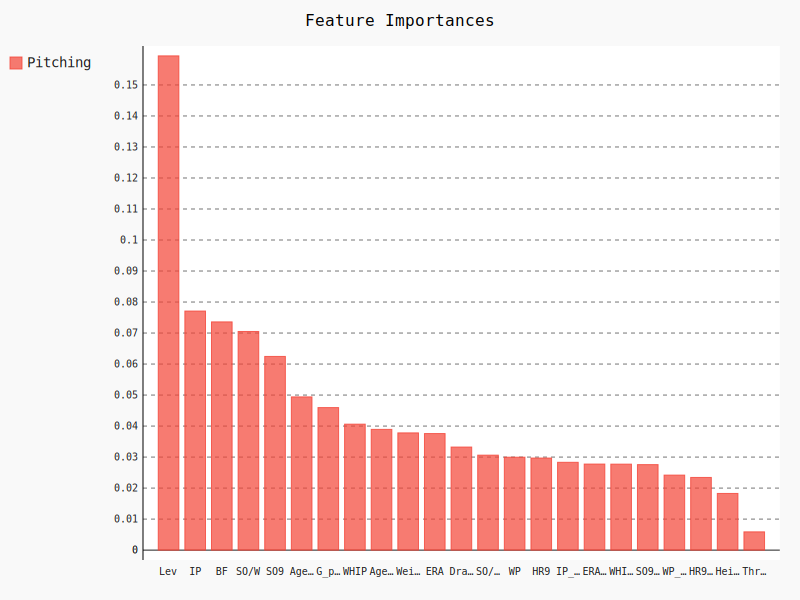

In [143]:
from IPython.display import SVG
line_chart = pygal.Bar()
line_chart.title = 'Feature Importances'
line_chart.x_labels = X_train_808.columns[indices]
line_chart.add('Pitching', importances[indices])

line_chart.render_to_png('feat_pit.png')
SVG(filename='routes.svg')
#line_chart.render_in_browser()

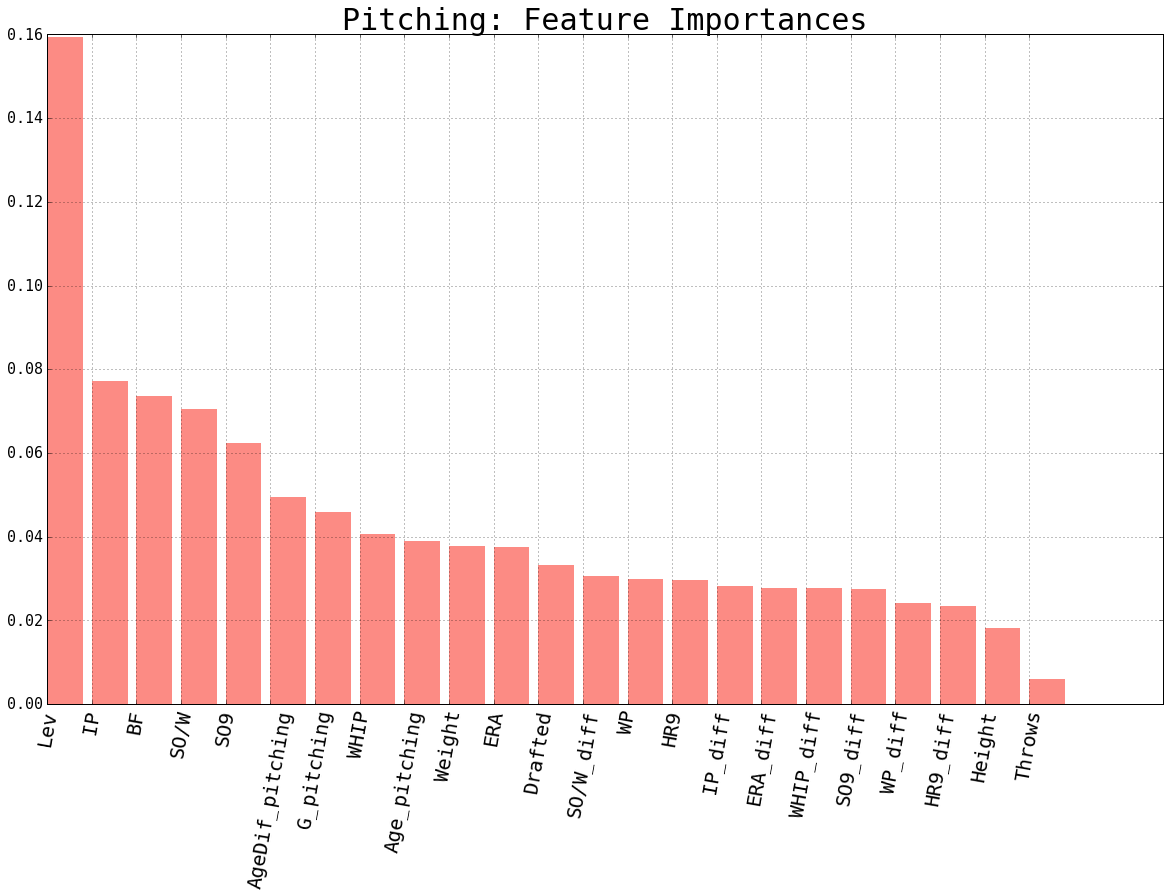

In [270]:
importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(20,12))
_ = plt.bar(range(X_train_808.shape[1]), importances[indices], label = X_train_808.columns[indices], color='#fc5a50',
           edgecolor=None, linewidth=0, alpha = 0.7)
_ = plt.xticks(range(X_train_808.shape[1]), X_train_808.columns[indices], rotation=80, fontsize=20, fontname='monospace')
_ = plt.yticks(fontname='monospace', fontsize=15)
plt.grid(True)
#plt.xlabel('Features', fontsize=14, fontweight='bold', style='italic')
#plt.ylabel('Relative Importance', fontsize=16, fontweight='bold', style='italic')
plt.title('Pitching: Feature Importances', fontsize=30, fontname='monospace')

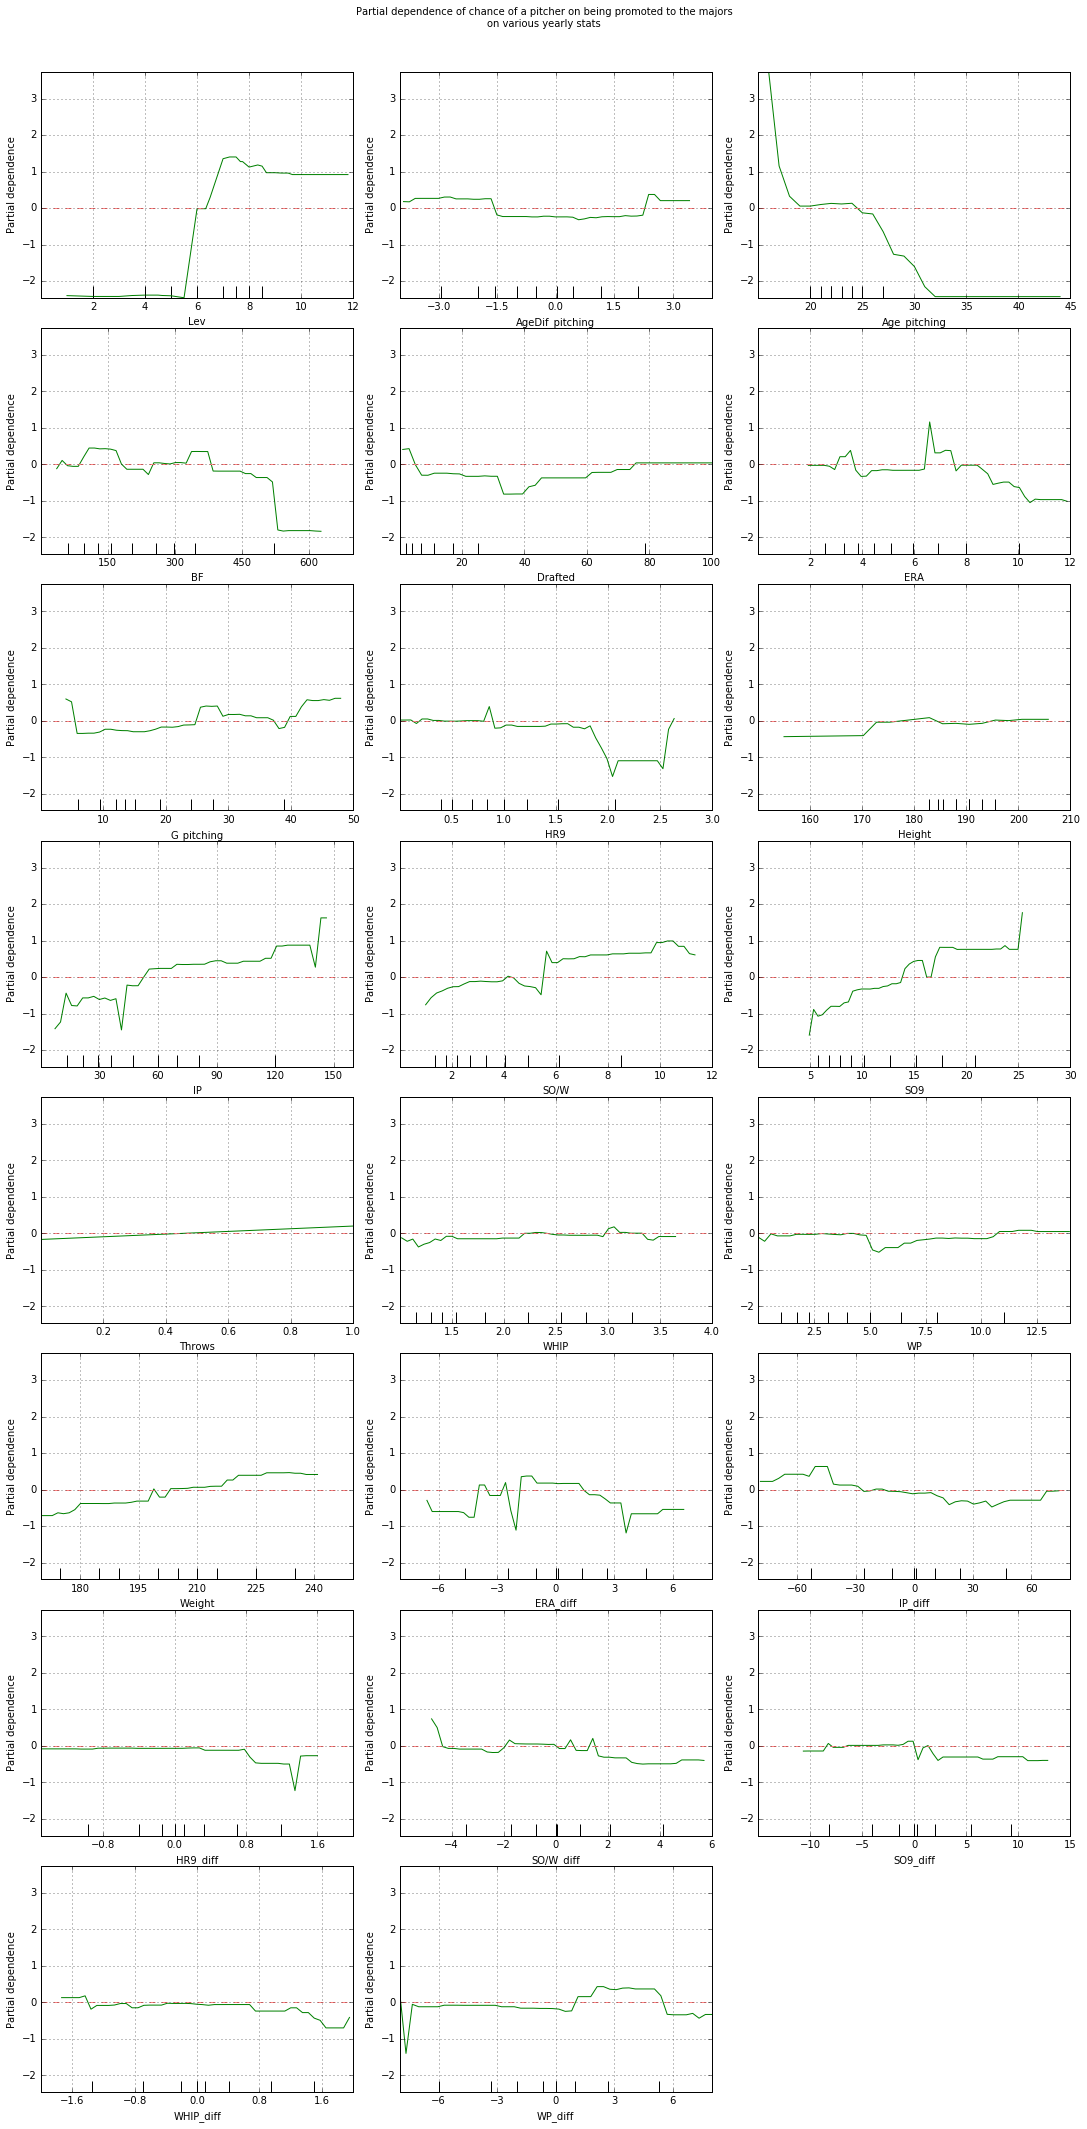

In [96]:
##### features = range(len(X.columns))
grbt = GradientBoostingClassifier(n_estimators=500)
grbt.fit(X_under_808, y_under_808)
names = X_ver2_808x.columns
features = range(len(X_ver2_808x.columns))
fig, axs = plot_partial_dependence(grbt, X_under_808, features,
                                   feature_names=names,
                                   n_jobs=3, grid_resolution=50, figsize=(15, 30),
                                   )
fig.suptitle('Partial dependence of chance of a pitcher on being promoted to the majors\n'
             'on various yearly stats')
for axes in axs:
    axes.grid(True)
    axes.axhline(0, linestyle='--', color='#ff8080')
    axes

plt.tight_layout(pad=0.4)
plt.subplots_adjust(top=0.95) 

In [245]:
y_test.value_counts()

0.0    19066
1.0      222
Name: Rookie?, dtype: int64

In [271]:
def gbplot_pie(fractions, #values for the wedges
              labels, #labels for the wedges
              title = '', #title of the pie chart
              cm_name = 'Pastel1', #name of the matplotlib colormap to use
              autopct = '%1.1f%%', #format the value text on each pie wedge
              labeldistance = 1.05, #where to place wedge labels in relation to pie wedges
              shadow = True, #shadow around the pie
              startangle = 90, #rotate 90 degrees to start the top of the data set on the top of the pie
              edgecolor = 'w', #color of pie wedge edges
              width = 8, #width of the figure in inches
              height = 8, #height of the figure in inches
              grouping_threshold = None, #group all wedges below this value into one 'all others' wedge
              grouping_label = None): #what the label the grouped wedge
    
    # if the user passed a threshold value, group all fractions lower than it into one 'misc' pie wedge
    if not grouping_threshold==None:
        
        # if user didn't pass a label, apply a default text
        if grouping_label == None:
            grouping_label = 'Others'

        # select the rows greater than the cutoff value
        row_mask = fractions > grouping_threshold
        meets_threshold = fractions[row_mask]

        # group all other rows below the cutoff value
        all_others = pd.Series(fractions[~row_mask].sum())
        all_others.index = [grouping_label]

        # append the grouped row to the bottom of the rows to display
        fractions = meets_threshold.append(all_others)
        labels = fractions.index
    
    # get the color map then pull 1 color from it for each pie wedge we'll draw
    color_map = cm.get_cmap(cm_name)
    num_of_colors = len(fractions)
    colors = color_map([x/float(num_of_colors) for x in range(num_of_colors)])
    
    # create the figure and an axis to plot on
    fig, ax = plt.subplots(figsize=[width, height])
    
    # plot the pie
    wedges = ax.pie(fractions, 
                    
                    labeldistance = labeldistance,
                    autopct = autopct,
                    colors = ['#fc5a50', colors[1]],
                    shadow = shadow,
                    explode=(0, 0.2),
                    startangle = startangle,
                   textprops={'weight':'bold', 'fontsize': 18})
    plt.title('Pitchers:\nPromoted to majors next year?', fontweight='bold', fontsize=20)
    # change the edgecolor for each wedge
    for wedge in wedges[0]:
        wedge.set_edgecolor(edgecolor)
    plt.legend(['No', 'Yes'], loc="best", fontsize=16)
    # set the title and show the plot
    #ax.set_title(title, fontproperties=title_font)
    plt.show()

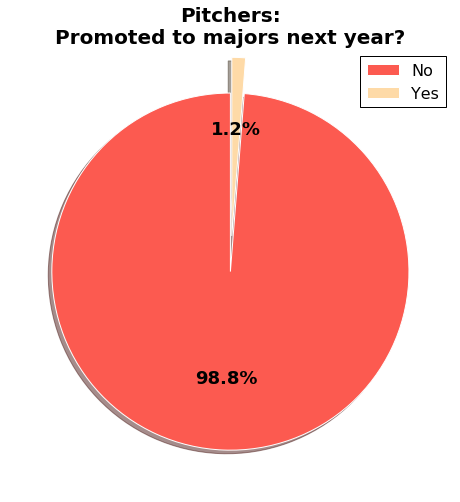

In [272]:
gbplot_pie(fractions = X_ver2['Rookie?'].value_counts(),
           labels=['No', 'Yes'],
           title = 'Cities, by share of records in data set',
           
           grouping_label = 'All Other Cities')


In [253]:
colors = ["#fc5a50", "#8e82fe", "#D63B59", "#AE5552", "#CB5C3B", "#EB8076", "#96624E"]

# Create a pie chart
plt.figure(figsize=(6,6))
plt.pie(
    # using data total)arrests
    X_ver2['Rookie?'].value_counts(),
    # with the labels being officer names
    #labels=['No', 'Yes'],
    # with no shadows
    shadow=True,
    # with colors
    colors=colors[:2],
    alpha=0.7,
    # with one slide exploded out
    explode=(0, 0.2),
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',
    pctdistance=0.5,
    textprops={'weight':'bold', 'fontsize': 18}
    )

# View the plot drop above
plt.axis('equal')
plt.title('Pitchers:\nPromoted to majors next year?', fontweight='bold', fontsize=20)
plt.legend(['No', 'Yes'], loc="best", fontsize=14)
# View the plot
plt.tight_layout()
plt.show()

TypeError: pie() got an unexpected keyword argument 'alpha'

In [246]:
y_test.shape

(19288,)

In [247]:
y_test_copy = y_test.copy()

In [248]:
y_test_copy.index = range(y_test_copy.shape[0])

In [251]:
pred_idx_1 = np.where(y_pred_logit == 1)

In [252]:
pred_idx_0 = np.where(y_pred_logit == 0)

In [253]:
FP_idx = np.intersect1d(true_idx_0, pred_idx_1) # 실제로는 0인데 1로 예상한것들

In [254]:
TP_idx = np.intersect1d(true_idx_1, pred_idx_1) # 실제로 1이고 1로 예상한것들

In [255]:
FN_idx = np.intersect1d(true_idx_1, pred_idx_0) # 실제로 1인데 0으로 예상한것들

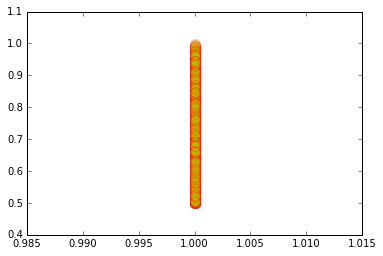

In [256]:
plt.scatter(y_pred_logit[FP_idx], y_proba_logit[:,1][FP_idx], alpha=0.2, s=100, c='y', edgecolor='red')

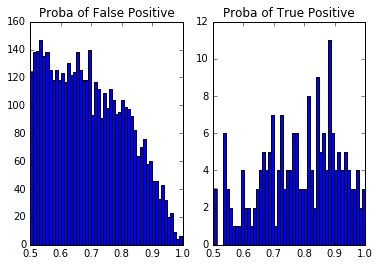

In [257]:
f, ax = plt.subplots(1, 2)
_ = ax[0].hist(y_proba_logit[:,1][FP_idx], bins=50)
ax[0].set_title('Proba of False Positive')
_ = ax[1].hist(y_proba_logit[:,1][TP_idx], bins=50)
ax[1].set_title('Proba of True Positive')

In [258]:
(y_proba_logit[:,1][TP_idx] > 0.75).sum()

118

In [259]:
(y_proba_logit[:,1][FP_idx] > 0.75).sum()

1562

In [260]:
thres = np.linspace(0.2, 1.0, 50)

In [261]:
TPR = []
Precision = []
for t in thres:
    TPR.append((y_proba_logit[:,1][TP_idx] > t).sum() / 222.)
    Precision.append((y_proba_logit[:,1][TP_idx] > t).sum() / ((y_proba_logit[:,1][FP_idx] > t).sum() + (y_proba_logit[:,1][TP_idx] > t).sum()))

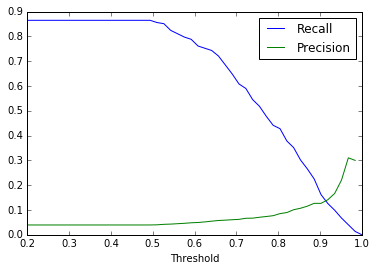

In [263]:
plt.plot(thres, TPR, label='Recall')
plt.plot(thres, Precision, label='Precision')
plt.legend()
plt.xlabel('Threshold')

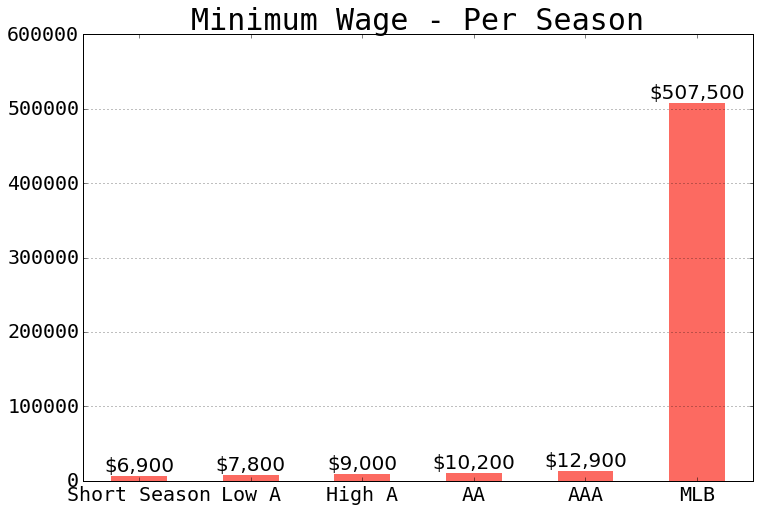

In [224]:
frequencies = [6900, 7800, 9000, 10200, 12900, 507500]   # bring some raw data

freq_series = pd.Series.from_array(frequencies)   # in my original code I create a series and run on that, so for consistency I create a series from the list.

x_labels = ['Short Season', 'Low A', 'High A', 'AA', 'AAA', 'MLB']

# now to plot the figure...
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar', color='#fc5a50',
           edgecolor=None, linewidth=0, alpha = 0.9)
ax.set_title("Minimum Wage - Per Season", fontsize=30, fontname='monospace')
#ax.set_xlabel()
#ax.set_ylabel("Amount ($)")
ax.set_xticklabels(x_labels, rotation=0, fontsize=20, fontname='monospace')
rects = ax.patches
_ = plt.yticks(fontname='monospace', fontsize=20)
ax.yaxis.grid(True)

# Now make some labels
labels = ['$6,900', '$7,800', '$9,000', '$10,200', '$12,900', '$507,500']

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 1000, label, ha='center', va='bottom', fontsize=20)

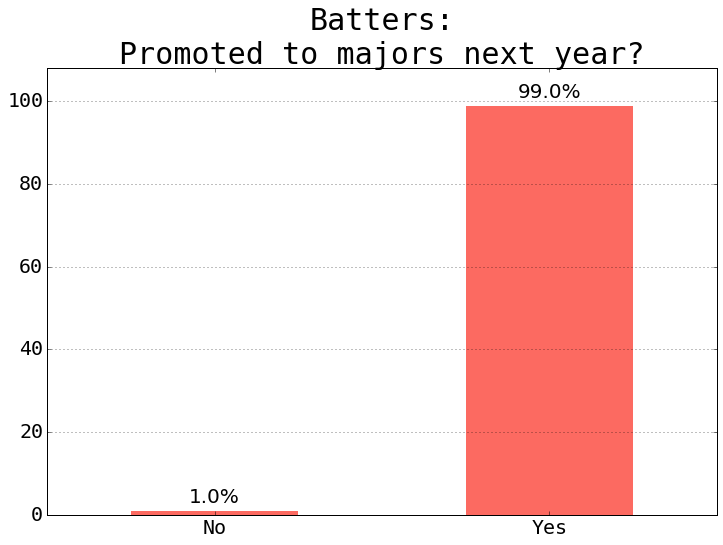

In [285]:
frequencies = [1, 99]   # bring some raw data

freq_series = pd.Series.from_array(frequencies)   # in my original code I create a series and run on that, so for consistency I create a series from the list.

x_labels = ['No', 'Yes']

plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar', color='#fc5a50',
           edgecolor=None, linewidth=0, alpha = 0.9)
ax.set_title("Batters:\nPromoted to majors next year?", fontsize=30, fontname='monospace')
#ax.set_xlabel()
#ax.set_ylabel("Amount ($)")
ax.set_xticklabels(x_labels, rotation=0, fontsize=20, fontname='monospace')
rects = ax.patches
_ = plt.yticks(fontname='monospace', fontsize=20)
ax.yaxis.grid(True)
plt.ylim(0, 108)
# Now make some labels
labels = ['1.0%', '99.0%']

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 1, label, ha='center', va='bottom', fontsize=20)